# Week2 One-way ANOVA with Variance-Stabilizing Transformations
## 背景描述
一位土木工程师试图确定4种不同的洪水流量估计方法在应用于同一流域时，是否能产生相同的峰值流量估计。现将每种方法在此流域中使用 6 次。  
这是一个因子水平数 𝑎 = 4 和重复次数 𝑛 = 6 的单因子实验。
## 数据描述
| 变量名 | 变量含义 | 变量取值范围 | 变量取值范围 |
| :----------: | :--------: | :----------: | :----------: |
| （自变量）Method | 洪水流量的估计方法 | categorical variable | [1, 2, 3, 4] |
| （因变量）Y | 洪水的峰值流量 | continuous variable (单位：每秒立方英尺) | $\mathbb{R}$ |


In [1]:
# import pandas as pd
# print('Data: \n', pd.read_csv('T3_7.csv').values)

## 问题 
注：这里使用 $\alpha=0.05$ 的显著性水平
1. 试判断 4 种洪水流量估计方法的峰值流量是否存在差异.
2. 试判断该实验残差是否具有异方差性.
3. 若实验中的残差具有异方差性，试判断峰值流量如何进行方差稳定化变换.
4. 如果需要变换，基于变换后的数据，试判断 4 种洪水流量估计方法的峰值流量是否存在差异.

## 解决方案
**Q1:**  
检验假设 $H_0: \mu_1 = \mu_2 = \mu_3 = \mu_4$ ;  $H_1: \mu_1, \mu_2, \mu_3, \mu_4$不全相等

In [2]:
# Import standard packages
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import special
import matplotlib.pyplot as plt
import math

# Import additional packages
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f

alpha = 0.05
a = 4
n = 6

x = pd.read_csv("T3_7.csv")
data = x.values[:,1:3]
# print(data)

# Sort them into groups, according to column 1("Method")
group1 = data[data[:,0] == 1,1]
group2 = data[data[:,0] == 2,1]
group3 = data[data[:,0] == 3,1]
group4 = data[data[:,0] == 4,1]

# Do the one-way ANOVA
df = pd.DataFrame(data, columns = ['method', 'value'])   
model = ols('value ~ C(method)', df).fit()#C里面是一个自变量
anovaResults = round(anova_lm(model), 2)
print('The ANOVA table: \n', anovaResults)

F0, pVal1 = stats.f_oneway(group1, group2, group3, group4)
# 法1：
# print(pVal1)
if pVal1 < alpha:
    print('\nSince p-value < 0.05, reject H0.')
else:
    print('\nAccept H0.') 
    
# 法2：
F = round(f.ppf(0.95,dfn = 3,dfd = 20), 2)
if F0 > F:
    print('Since F0 > F(0.05, 3, 20) = ', F, ', reject H0.')
else:
    print('Accept H0.') 


The ANOVA table: 
              df  sum_sq  mean_sq      F  PR(>F)
C(method)   3.0  708.35   236.12  76.07     0.0
Residual   20.0   62.08     3.10    NaN     NaN

Since p-value < 0.05, reject H0.
Since F0 > F(0.05, 3, 20) =  3.1 , reject H0.


由方差分析表可知，P值小于 0.05 且F值大于 3.10，故拒绝原假设，即 4 种洪水流量估计方法的峰值流量存在差异。

**Q2:**  
ANOVA模型： 
$y_{ij} = \mu + \tau_i + \epsilon_{ij}$ 的误差服从正态独立分布，其均值为零，方差为未知的常数$\sigma^2$。 
想要判断ANOVA模型是否恰当，可以利用残差检测来进行分析。  
处理 $i$ 的观测值 $j$ 的残差定义为：$e_{ij} = y_{ij} - \hat{y}_{ij}$  
其中$\hat{y}_{ij}$是对应于$y_{ij}$的一个估计， 
$\hat{y}_{ij} = \hat{\mu} + \hat{\tau}_i = \overline{y}_{··} + (\overline{y}_{i·} - \overline{y}_{··}) = \overline{y}_{i·}$  

检验假设：$𝐻_0:\sigma_1^2 = \sigma_2^2 = ⋯ = \sigma_a^2$  vs $𝐻_1:\sigma_i^2 \neq \sigma_j^2, ∃ i \neq j$  
异方差性的判断依据：

Bartlett检验的P值为： 0.0293
Since p-value < 0.05, reject H0.

Levene检验的P值为： 0.0136
Since p-value < 0.05, reject H0.



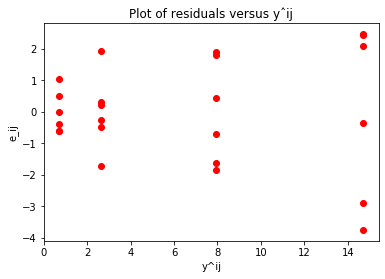

In [3]:
# 计算峰值流量的残差
data_res = data.astype(float) * 1
for k in range(a):
    cnt = data_res[data_res[:,0] == k + 1,1]
    data_res[data_res[:,0] == k + 1,1] = cnt - np.mean(cnt)
# print(data_res)

# 法1：残差与拟合值的关系图
res = data_res[:,1]
y = []
for i in range(a):
    for j in range(n):
        y.append(np.mean(data[(data[:,0] == i + 1),1]))
plt.scatter(y, res, c = "red")
plt.title('Plot of residuals versus yˆij')
plt.xlabel('y^ij')
plt.ylabel('e_ij')

# 法2：用Bartlett检验进行方差齐性检验
bart, pVal2 = stats.bartlett(group1, group2, group3, group4)
bart_stat = stats.chi2.isf(alpha, a - 1)
print('Bartlett检验的P值为：', round(pVal2, 4))
if pVal2 < alpha:
    print('Since p-value < 0.05, reject H0.')
else:
    print('Accept H0')  

# 法3：用Levene检验进行方差齐性检验
lene, pVal3 = stats.levene(group1, group2, group3, group4)
print('\nLevene检验的P值为：', round(pVal3, 4))
if pVal3 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n')  
# 1-画图比较残差和拟合值的关系
# 2-Bartlett检验和Levene检验进行方差齐性检验

由分析可知:  
1. 残差与拟合值的关系图：呈现开口向外的漏斗型；
2. Bartlett 检验法：P值为 0.0293 < 0.05；
3. Levene检验法：P值为 0.0136 < 0.05.  

结论：拒绝方差相等的原假设。

**Q3:**  
由第二题的结论可知，残差具有异方差性。为了研究峰值流量如何采用方差稳定化变换，需画出$logS_i$和$log\overline{y}_{i·}$的关系图。

In [4]:
#做方差稳定性变换：理论推导
#求上午推导的某个斜率

斜率为： 0.45


Text(0, 0.5, 'log_Si')

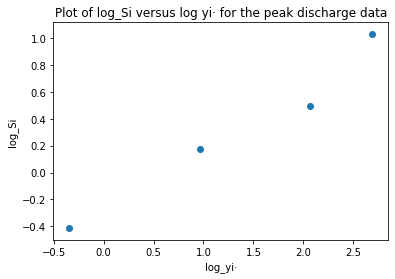

In [5]:
# 求出各估计方法的标准差sigma_i和均值mu_i的对数
# 通常用样本的标准差std_i和均值y_i代替总体的标准差sigma_i和均值mu_i
log_y_1 = math.log(np.mean(group1))
log_y_2 = math.log(np.mean(group2))
log_y_3 = math.log(np.mean(group3))
log_y_4 = math.log(np.mean(group4))
log_y = [log_y_1, log_y_2, log_y_3, log_y_4]

log_std_1 = math.log(np.std(group1, ddof = 1))
log_std_2 = math.log(np.std(group2, ddof = 1))
log_std_3 = math.log(np.std(group3, ddof = 1))
log_std_4 = math.log(np.std(group4, ddof = 1))
log_std = [log_std_1, log_std_2, log_std_3, log_std_4]

# linregress(x,y)线性回归函数 ：拟合求斜率 
# 因为我事先不知道分布是什么，需要凭经验找到其变换的方法
slope, intercept, r_value, p_value, std_err = stats.linregress(log_y, log_std)
print('斜率为：', round(slope, 2))

# 作图
plt.scatter(log_y, log_std)
plt.title('Plot of log_Si versus log yi· for the peak discharge data')
plt.xlabel('log_yi·')
plt.ylabel('log_Si')


由上图可知，过这 4 点的直线斜率接近 $1/2$ ，即 $\alpha= 1/2$。根据 $\lambda = 1−\alpha，\lambda = 1/2$。可知平方根是适合的。变换后的数据为 $𝑦^* = \sqrt{𝑦}$ 。

变换的方式为：对 y 值开方，即通过开根号进行方差稳定化变换

Text(0, 0.5, 'e_ij*')

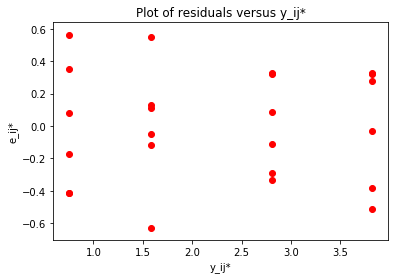

In [6]:
# 对y值开方，即通过开根号进行方差稳定化变换，因为alpha=0.5,注意是针对原始数据进行变换的
sqrt_group1 = group1 ** 0.5
sqrt_group2 = group2 ** 0.5
sqrt_group3 = group3 ** 0.5
sqrt_group4 = group4 ** 0.5
sqrt_groups = [sqrt_group1, sqrt_group2, sqrt_group3, sqrt_group4]
sqrt_groups1 = pd.DataFrame(sqrt_groups)
# print(sqrt_groups1)

# 计算变换后峰值流量的残差
df = np.array(sqrt_groups)
sqrt_data = [data[:,0], df.reshape(1, 24).tolist()[0]]
sqrt_data = np.array(sqrt_data * 1).T
sqrt_data_res = sqrt_data * 1
for k in range(a):
    sqrt_cnt = sqrt_data_res[sqrt_data_res[:,0] == k + 1,1]
    sqrt_data_res[sqrt_data_res[:,0] == k + 1,1] = sqrt_cnt - np.mean(sqrt_cnt)

# 变换后的残差与拟合值的关系图
sqrt_res = sqrt_data_res[:,1]
sqrt_y = []
for i in range(a):
    for j in range(n):
        sqrt_y.append(np.mean(sqrt_data[(sqrt_data[:,0] == i + 1),1]))
plt.scatter(sqrt_y, sqrt_res, c = "red")
plt.title('Plot of residuals versus y_ij*')
plt.xlabel('y_ij*')
plt.ylabel('e_ij*')

【补充】Box-Cox变换：Box-Cox变换的主要特点是引入一个参数 $\lambda$，通过数据本身估计该参数进而确定应采取的数据变换形式，Box-Cox变换可以明显地改善数据的正态性、方差齐性。  
Box-Cox变换的一般形式为：  
$$ y(\lambda)=\left\{
\begin{aligned}
\frac{(y+c)^{\lambda}-1}{\lambda} & ,&\lambda \neq 0 \\
\ln (y+c) & ,& \lambda = 0 
\end{aligned}
\right.
$$
式中$y(\lambda)$为经Box-Cox变换后得到的新变量，$y$ 为原始连续因变量，其中 $y+c$ 的 $+c$ 是为了确保 $(y+c)>0$,因为在Box-Cox变换中要求 $y>0$，$\lambda$ 为变换参数。  
在这里可以看到 $\lambda$ 的值是需要我们自己去确定的，那么怎么去确定呢？这里使用的方法是假设经过转换后的因变量就是服从正态分布的，然后画出关于 $\lambda$ 的似然函数，似然函数值最大的时候 $\lambda$ 的取值就是这里需要确定的值。

In [7]:
# 增添y+c偏移量保证非负性

lmax_mle:  0.3385474390155809
lmax_pearsonr:  0.40024257376691824


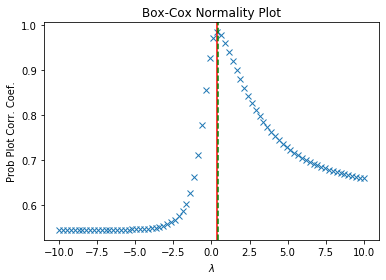

Text(0, 0.5, 'e_ij*')

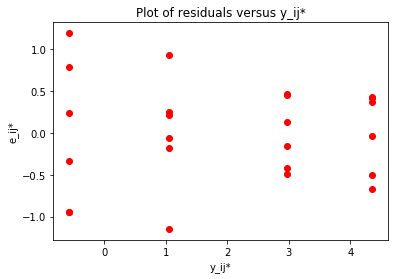

In [8]:
 #作Box-Cox变换
bc, lmax_mle = stats.boxcox(data[:,1])
lmax_pearsonr = stats.boxcox_normmax(data[:,1])
print('lmax_mle: ', lmax_mle)
print('lmax_pearsonr: ', lmax_pearsonr)

fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(data[:,1], -10, 10, plot = ax)
ax.axvline(lmax_mle, color='r')
ax.axvline(lmax_pearsonr, color='g', ls='--')
plt.show()

# 计算变换后峰值流量的残差
bc_group1 = bc[0:6]
bc_group2 = bc[6:12]
bc_group3 = bc[12:18]
bc_group4 = bc[18:24]
bc_groups = [bc_group1, bc_group2, bc_group3, bc_group4]
bc_groups1 = pd.DataFrame(bc_groups)
# print(bc_groups1)
df = np.array(bc_groups)
bc_data = [data[:,0], df.reshape(1, 24).tolist()[0]]
bc_data = np.array(bc_data * 1).T
bc_data_res = bc_data * 1
for k in range(a):
    bc_cnt = bc_data_res[bc_data_res[:,0] == k + 1,1]
    bc_data_res[bc_data_res[:,0] == k + 1,1] = bc_cnt - np.mean(bc_cnt)

# 变换后的残差与拟合值的关系图
bc_res = bc_data_res[:,1]
bc_y = []
for i in range(a):
    for j in range(n):
        bc_y.append(np.mean(bc_data[(bc_data[:,0] == i + 1),1]))
plt.scatter(bc_y, bc_res, c = "red")
plt.title('Plot of residuals versus y_ij*')
plt.xlabel('y_ij*')
plt.ylabel('e_ij*')
# 找的lambda是似然函数的最大值 可解释性=>alpha=0.5


Q4:

In [9]:
# 开根号后，再用Levene检验进行方差齐性检验
sqrt_lene, pVal4 = stats.levene(sqrt_group1, sqrt_group2, sqrt_group3, sqrt_group4)
if pVal4 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n')  
    
# Box-Cox变换后，再用Levene检验进行方差齐性检验 
bc_lene, pVal5 = stats.levene(bc_group1, bc_group2, bc_group3, bc_group4)
if pVal5 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n') 

# 开根号后，Do the one-way ANOVA with transformation of square root
sqrt_F0, pVal6 = stats.f_oneway(sqrt_group1, sqrt_group2, sqrt_group3, sqrt_group4)
if pVal6 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n') 
    
# Box-Cox变换后，Do the one-way ANOVA with transformation of square root
bc_F0, pVal7 = stats.f_oneway(bc_group1, bc_group2, bc_group3, bc_group4)
if pVal7 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n') 

# Elegant alternative implementation, with pandas & statsmodels
for i in range(a):
    data[0 + 6 * i:6 * (i + 1), 1] = list(sqrt_groups[i])
#     data[0 + 6 * i:6 * (i + 1), 1] = list(bc_groups[i])
df = pd.DataFrame(data, columns = ['method', 'Y'])   
model = ols('Y ~ C(method)', df).fit()
anovaResults = anova_lm(model)
print(anovaResults)

Accept H0

Accept H0

Since p-value < 0.05, reject H0.

Since p-value < 0.05, reject H0.

             df     sum_sq    mean_sq          F        PR(>F)
C(method)   3.0  32.684213  10.894738  81.048985  2.296069e-11
Residual   20.0   2.688433   0.134422        NaN           NaN


In [12]:
sqrt_groups

[array([0.58309519, 0.34641016, 1.10905365, 0.83666003, 1.32287566,
        0.34641016]),
 array([0.9539392 , 1.71464282, 1.46287388, 1.53622915, 1.69115345,
        2.1330729 ]),
 array([2.51197134, 2.89309523, 3.122499  , 2.46779254, 3.13368792,
        2.69072481]),
 array([4.14125585, 3.43802269, 3.30907842, 4.14728827, 3.78813938,
        4.10121933])]

In [11]:
data

array([[1.        , 0.58309519],
       [1.        , 0.34641016],
       [1.        , 1.10905365],
       [1.        , 0.83666003],
       [1.        , 1.32287566],
       [1.        , 0.34641016],
       [2.        , 0.9539392 ],
       [2.        , 1.71464282],
       [2.        , 1.46287388],
       [2.        , 1.53622915],
       [2.        , 1.69115345],
       [2.        , 2.1330729 ],
       [3.        , 2.51197134],
       [3.        , 2.89309523],
       [3.        , 3.122499  ],
       [3.        , 2.46779254],
       [3.        , 3.13368792],
       [3.        , 2.69072481],
       [4.        , 4.14125585],
       [4.        , 3.43802269],
       [4.        , 3.30907842],
       [4.        , 4.14728827],
       [4.        , 3.78813938],
       [4.        , 4.10121933]])

In [10]:
# 这里自由度 20 v.s. 19?

由第一个结论可知，稳定化变换后的残差具有方差齐性。再进行单因素方差分析，由方差分析表知，P值小于0.05，故拒绝原假设，即 4 种洪水流量估计方法的峰值流量存在差异。

## 第二周练习题
数据集：Project2.csv(内附文档)  
统计方法：One-way ANOVA    
软件：Jupyter Notebook  
作业发到邮箱：51205903029@stu.ecnu.edu.cn  
压缩包名字：学号-姓名  
Deadline：下周一晚上7：00之前交  
注：要有完整的解题过程，不能只有代码